# Pre-requisite

## 1) Package required

In [1]:
!pip install sklearn pandas pandas_profiling seaborn

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from pandas_profiling import ProfileReport as report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## 2) Dataset

In [3]:
!mkdir -p data
!wget -P data https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
!wget -P data https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names

--2021-04-25 15:52:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [application/x-httpd-php]
Saving to: 'data/processed.cleveland.data'

processed.cleveland 100%[===================>]  18.03K  88.1KB/s    in 0.2s    

2021-04-25 15:52:22 (88.1 KB/s) - 'data/processed.cleveland.data' saved [18461/18461]

--2021-04-25 15:52:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent,

In [4]:
# Description of the dataset; Useful for naming the attributes below
!cat data/heart-disease.names

Publication Request: 
   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
   This file describes the contents of the heart-disease directory.

   This directory contains 4 databases concerning heart disease diagnosis.
   All attributes are numeric-valued.  The data was collected from the
   four following locations:

     1. Cleveland Clinic Foundation (cleveland.data)
     2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
     3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
     4. University Hospital, Zurich, Switzerland (switzerland.data)

   Each database has the same instance format.  While the databases have 76
   raw attributes, only 14 of them are actually used.  Thus I've taken the
   liberty of making 2 copies of each database: one with all the attributes
   and 1 with the 14 attributes actually used in past experiments.

   The authors of the databases have requested:

      ...that any publications resulting from the use of th

## Exploratory Data Analysis

In [5]:
dataset_path = "data/processed.cleveland.data"
raw_data_frame = pd.read_csv(dataset_path)

# Meaningful names for the columns from above description
raw_data_frame.columns = ['Age',
                          'Sex',
                          'Chest_pain_type',
                          'Resting_blood_pressure', 
                          'Cholesterol',
                          'Fasting_blood_sugar',
                          'Resting_electro_cardiographic',
                          'Max_heart_rate',
                          'exercise_induced_angina', 
                          'Depression',
                          'Slope_type',
                          'Num_major_vessels',
                          'Thalassemia_type',
                          'Prediction']

In [6]:
# Quick overview of the dataset
report(raw_data_frame)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Clean up the data

In [7]:
# Few values seems to be missing with values "?"
# lets look at them and later remove
raw_data_frame.query('Thalassemia_type == "?"')

,Age,Sex,Chest_pain_type,Resting_blood_pressure,Cholesterol,Fasting_blood_sugar,Resting_electro_cardiographic,Max_heart_rate,exercise_induced_angina,Depression,Slope_type,Num_major_vessels,Thalassemia_type,Prediction
86,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
265,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2


In [8]:
raw_data_frame.query('Num_major_vessels == "?"')

,Age,Sex,Chest_pain_type,Resting_blood_pressure,Cholesterol,Fasting_blood_sugar,Resting_electro_cardiographic,Max_heart_rate,exercise_induced_angina,Depression,Slope_type,Num_major_vessels,Thalassemia_type,Prediction
165,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
191,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
286,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
301,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [9]:
raw_data_frame.drop([86, 265, 165, 191, 286, 301], inplace=True)

In [10]:
# Convert the prediction into a binary classification problem
raw_data_frame['Prediction'] = ((raw_data_frame['Prediction'] > 0) * 1).copy()

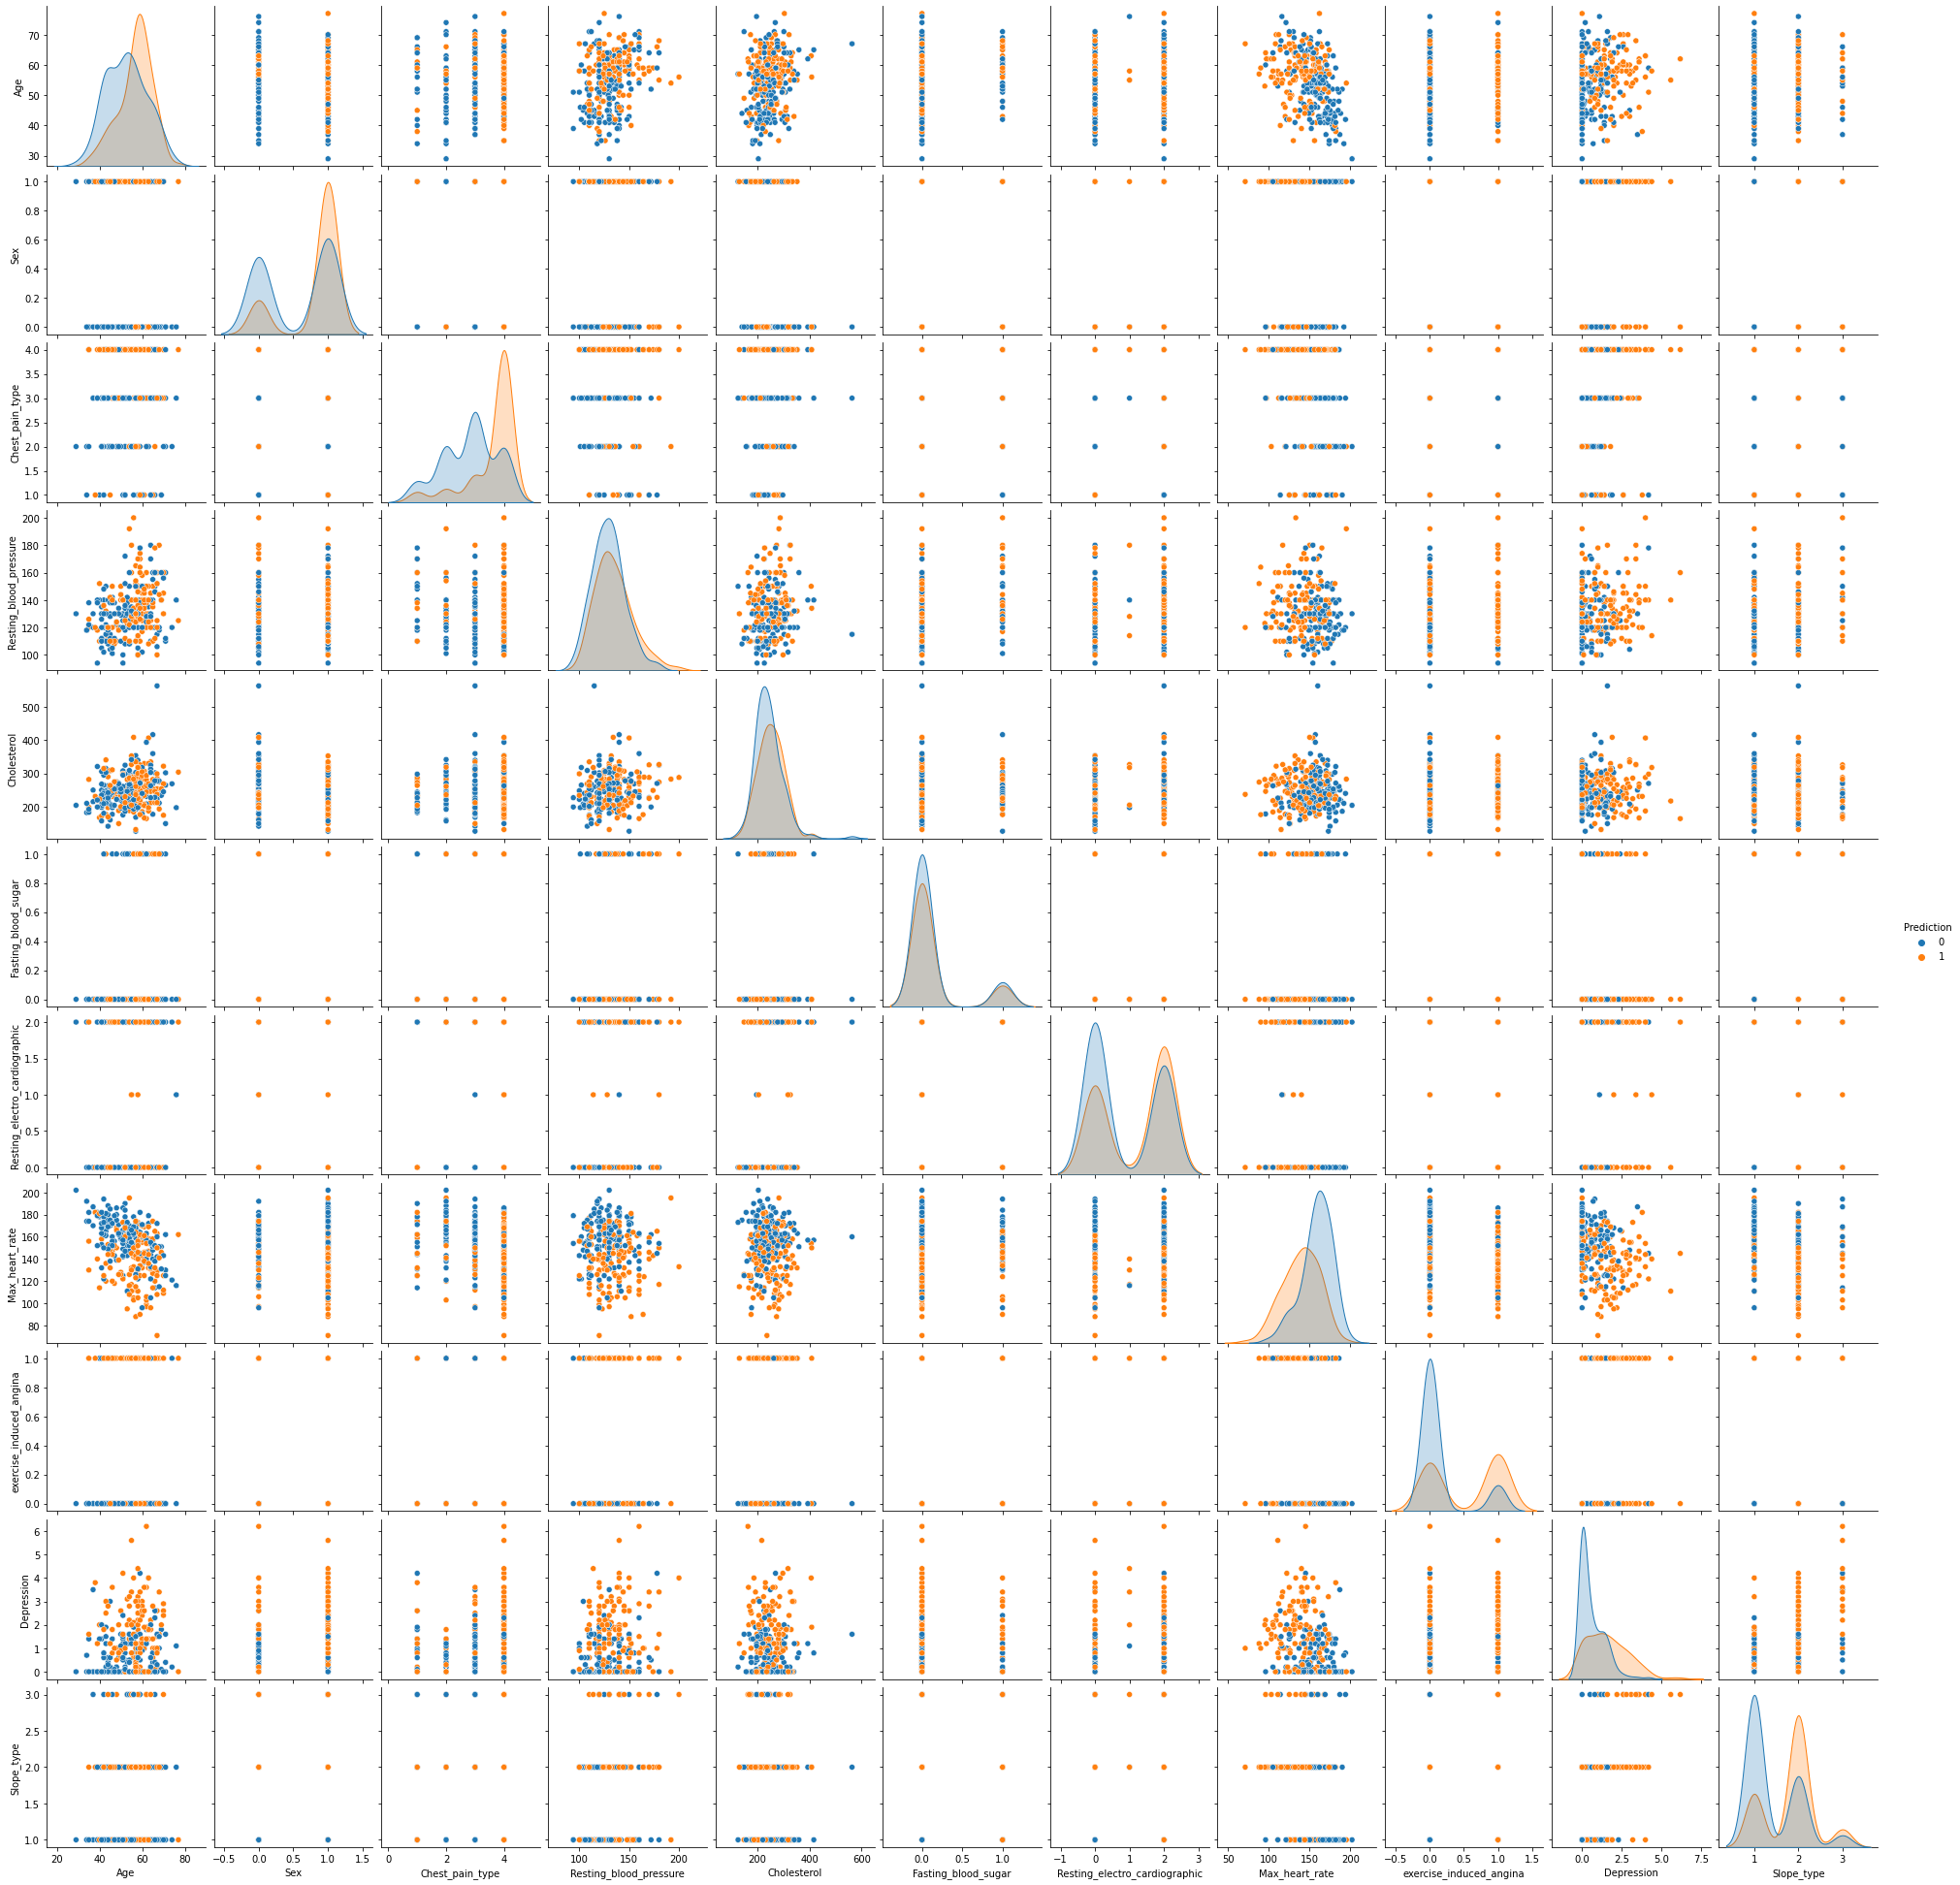

In [11]:
# Who wouldn't love some pair plot ?
sns.pairplot(raw_data_frame,hue='Prediction')

In [12]:
# Get the input feature and prediction separated.
X, y = raw_data_frame.iloc[:,:-1], raw_data_frame['Prediction']

In [13]:
# Onehot encode the categorical data points.
X = pd.get_dummies(X, 
                   columns=['Resting_electro_cardiographic',
                            'Chest_pain_type',
                            'Slope_type',
                            'Thalassemia_type',
                            'Num_major_vessels'],
                   drop_first=False)

# Normailzing the inputs.
X = (X - np.min(X)) / (np.max(X) - np.min(X)).values

X.head()

,Age,Sex,Resting_blood_pressure,Cholesterol,Fasting_blood_sugar,Max_heart_rate,exercise_induced_angina,Depression,Resting_electro_cardiographic_0.0,Resting_electro_cardiographic_1.0,...,Slope_type_1.0,Slope_type_2.0,Slope_type_3.0,Thalassemia_type_3.0,Thalassemia_type_6.0,Thalassemia_type_7.0,Num_major_vessels_0.0,Num_major_vessels_1.0,Num_major_vessels_2.0,Num_major_vessels_3.0
0,0.791667,1.0,0.622642,0.365297,0.0,0.282443,1.0,0.241935,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.791667,1.0,0.245283,0.235160,0.0,0.442748,1.0,0.419355,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.166667,1.0,0.339623,0.283105,0.0,0.885496,0.0,0.564516,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.250000,0.0,0.339623,0.178082,0.0,0.770992,0.0,0.225806,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.562500,1.0,0.245283,0.251142,0.0,0.816794,0.0,0.129032,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Top features 

<AxesSubplot:>

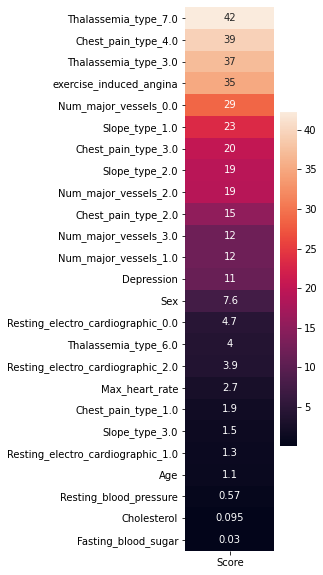

In [14]:
# Intresting to see the best features to help predict the label
feature_model = SelectKBest(score_func=chi2,
                           k=25).fit(X,y)

feature_score = pd.DataFrame(
    feature_model.scores_,
    X.columns,
    columns=['Score'])
feature_score.sort_values(by=['Score'],
                          inplace=True,
                          ascending=False)
plt.figure(figsize=(2,10))
sns.heatmap(feature_score,
            annot=True)

## Training Model

In [15]:
# Split the dataset into stratify 20 percent split.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=321,
                                                    shuffle=True,
                                                    stratify=y,
                                                    test_size=0.20)

# Train and predict on the test set.
model = LogisticRegression(max_iter=100,
                           tol=1e-4,
                           penalty='l1',
                           solver='liblinear', #{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
                           class_weight='balanced'
                          )
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

## Evaluation

In [16]:
# Useful metrics to evalute the model on
eval_metrics = {"Accuracy": accuracy_score,
                "Precision": precision_score,
                "Recall": recall_score,
                "F1 score": f1_score
               }

for k, v in eval_metrics.items():
    print(f"{k} : {v(y_test,y_pred)}")

Accuracy : 0.9166666666666666
Precision : 0.9259259259259259
Recall : 0.8928571428571429
F1 score : 0.9090909090909091


<AxesSubplot:>

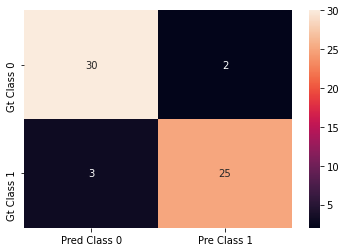

In [17]:
# To further breakdown the prediction with respect to classes.
sns.heatmap(confusion_matrix(y_test,
                             y_pred),
            xticklabels=['Pred Class 0', 'Pre Class 1'],
            yticklabels=['Gt Class 0', 'Gt Class 1'],
            annot=True)

<AxesSubplot:>

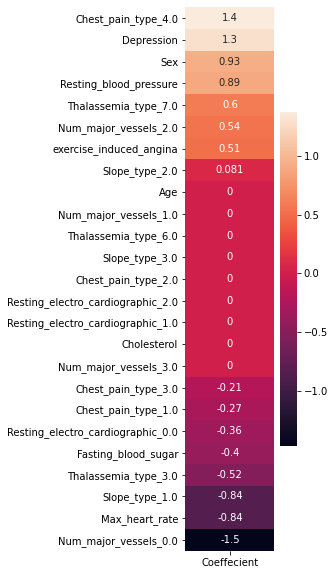

In [18]:
#Finally the features that model finds useful.
models_coeff = pd.DataFrame(model.coef_.ravel(),
                            X.columns,
                           columns=['Coeffecient'])
models_coeff.sort_values(by=['Coeffecient'],
                         inplace=True,
                         ascending=False)
plt.figure(figsize=(2,10))
sns.heatmap(models_coeff,
            annot=True)

## The END